In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'
scratch = '/scratch/08811/aew492/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
import illustris_python as il
import Corrfunc
from Corrfunc.theory.xi import xi
import astropy.units as u
import os
import sys
sys.path.insert(0, work)
import corrfunc_ls
from illustris_sim import IllustrisSim
from illustris_xi import compute_xi_auto_illustris
import tools

Compare galaxy autocorrelation function between TNG300-2 and TNG300-3.

#### set up simulations

In [4]:
z = 0.
# initialize simulation and snapshot
sim2 = IllustrisSim('TNG300-2')
sim3 = IllustrisSim('TNG300-3')
sim2.set_snapshot(redshift=z)
sim3.set_snapshot(redshift=z)

TNG300-2: snapshot (099) not found


#### load galaxies

In [5]:
sim2.load_galaxies(prints=True)
sim3.load_galaxies(prints=True)

loaded 2471022 subhalos for TNG300-2
removed 4388 flagged subhalos
TNG300-2: loaded 66815 subhalos with > 100 stars and star mass > 0
loaded 391144 subhalos for TNG300-3
removed 354 flagged subhalos
TNG300-3: loaded 4377 subhalos with > 100 stars and star mass > 0


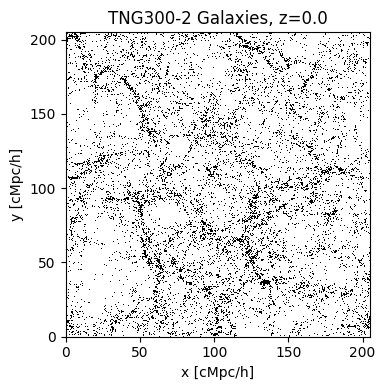

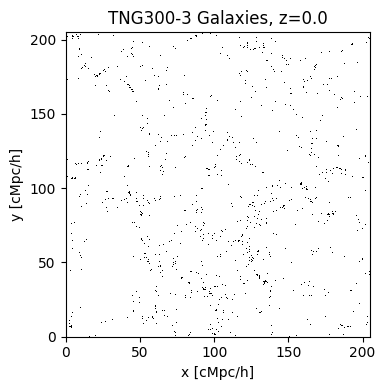

In [6]:
sims = [sim2, sim3]
for i, sim in enumerate(sims):
    fig, ax = plt.subplots(figsize=(5.5,4))
    # slice
    zslice = np.where(sim.gal_pos[:,2].value<50.)
    ax.plot(sim.gal_pos[:,0][zslice].value, sim.gal_pos[:,1][zslice].value, ls='None', marker=',', color='k')
    ax.set_xlim([0,205])
    ax.set_ylim([0,205])
    ticks = np.linspace(0, 200, 5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_aspect('equal')
    ax.set_xlabel('x [cMpc/h]')
    ax.set_ylabel('y [cMpc/h]')
    ax.set_title(f'{sim.sim} Galaxies, z={z}')
    fig.tight_layout()

#### galaxy autocorrelation

In [7]:
# load in DM autocorrelation to compare
xi_dm_auto = np.load(os.path.join(scratch, f'xi/xi_dm_{sim3.sim}_z-{z:.2f}_nx-10.npy'), allow_pickle=True).item()

In [8]:
# parameters
randmult = 3
rmin = 0.1
rmax = 50.
nbins = 20
nthreads = 12
print(rmin, rmax, nbins)

0.1 50.0 20


In [9]:
%%time
nrepeats = 10
xi_galss = np.empty((2,nbins))
for i, sim in enumerate(sims):
    xi_gals = np.empty((nrepeats, nbins))
    for j in range(nrepeats):
        ravg, xi_gals[j] = corrfunc_ls.compute_3D_ls_auto(sim.gal_pos.value, randmult, rmin, rmax,
                                            nbins, logbins=True, periodic=True, nthreads=nthreads, prints=False)
    xi_galss[i] = np.mean(xi_gals, axis=0)

CPU times: user 59.1 s, sys: 15.3 ms, total: 59.1 s
Wall time: 6.29 s


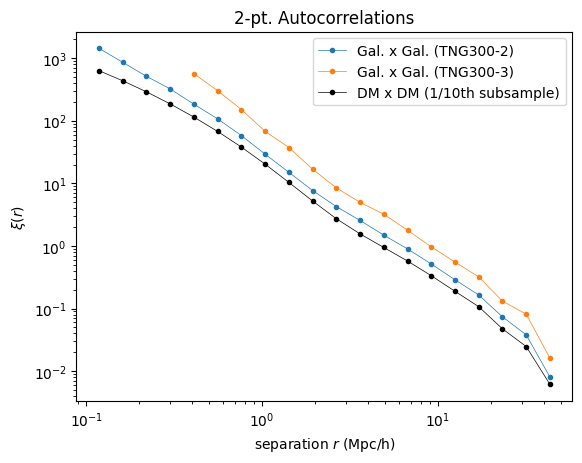

In [10]:
fig, ax = plt.subplots()

for i, sim in enumerate(sims):
    ax.plot(ravg, xi_galss[i], marker='.', lw=0.5, label=f'Gal. x Gal. ({sim.sim})')
ax.plot(xi_dm_auto['ravg'], xi_dm_auto['xi'], 'k.-', lw=0.5, label='DM x DM (1/10th subsample)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title(f'2-pt. Autocorrelations')
ax.legend()

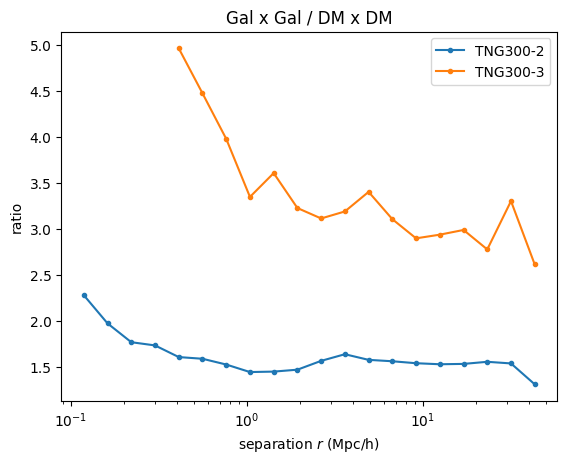

In [22]:
fig, ax = plt.subplots()
for i, sim in enumerate(sims):
    ax.plot(ravg, xi_galss[i]/xi_dm_auto['xi'], '.-', label=sim.sim)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'ratio')
ax.set_title(f'Gal x Gal / DM x DM')
ax.legend()

### linear theory from Colossus

In [23]:
# set cosmology: same as used by Illustris, Planck 2015
cosmo_model = 'planck15'
cosmo = cosmology.setCosmology(cosmo_model, persistence='r')  # persistence='r' sets this to read-only

In [24]:
# matter power spectrum
k = np.logspace(-5.0, 2.0, 500)
Pk = cosmo.matterPowerSpectrum(k)  # defaults to the approximation of Eisenstein & Hu 1998

In [25]:
# 2-pt. matter-matter correlation function is an integral over the power spectrum:
xi_linear = cosmo.correlationFunction(ravg, z=z)

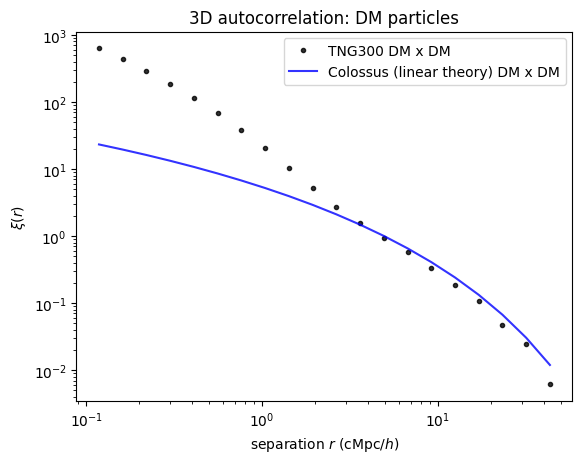

In [26]:
fig, ax = plt.subplots()
ax.plot(ravg, xi_dm_auto['xi'], color='k', marker='.', ls='None', alpha=0.8, label=f'TNG300 DM x DM')
ax.plot(ravg, xi_linear, color='b', alpha=0.8, label='Colossus (linear theory) DM x DM')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (cMpc/$h$)')
ax.set_ylabel(r'$\xi (r)$')
ax.set_title(r'3D autocorrelation: DM particles')
ax.legend()

#### ratio of gal x gal to linear theory: 

$\sqrt{\xi_\mathrm{gal\,x\,gal}(r)/\xi_\mathrm{linear}(r)}$ gives an estimate of the bias factor

In [27]:
bias_estimates = np.array([np.sqrt(xi_gal/xi_linear) for xi_gal in xi_galss])

In [28]:
bias_estimates.shape

(2, 20)

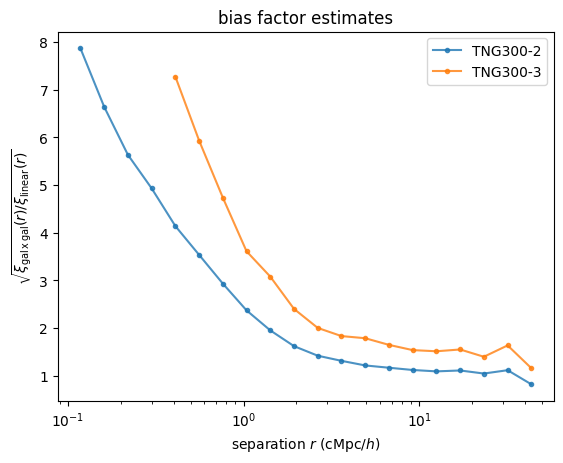

In [30]:
fig, ax = plt.subplots()
for i, sim in enumerate(sims):
    ax.plot(ravg, bias_estimates[i], marker='.', ls='-', alpha=0.8, label=sim.sim)
ax.set_xscale('log')
ax.set_xlabel(r'separation $r$ (cMpc/$h$)')
ax.set_ylabel(r'$\sqrt{\xi_\mathrm{gal\,x\,gal}(r)/\xi_\mathrm{linear}(r)}$')
ax.set_title(r'bias factor estimates')
ax.legend()